In [49]:
import torch
import torch.nn as nn  
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm
 

In [50]:
# Transforming the dataset
class DataLoaderBuilder():
    def __init__(self, root_path, image_size=(64, 64), batch_size=64, mean=0.5, std=0.5, shuffle=True):
        self.root_path = root_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.mean = mean
        self.std = std
        self.shuffle = shuffle
    
    def get_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize([self.mean], [self.std])
        ])

        # Dataset
        dataset = datasets.ImageFolder(root=self.root_path, transform=transform)
        
        # DataLoader
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)
        return dataloader

In [51]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, feature_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input is of shape N x (input_channels) x 64 x 64
            nn.Conv2d(input_dim, feature_dim, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim, feature_dim * 2, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim * 2, feature_dim * 4, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim * 4, feature_dim * 8, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),  # 1x1
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, x):
        return self.model(x)

In [52]:
# Testing the Discriminator class
example = torch.randn((10,3,64,64))
D = Discriminator(3,64)
print(D(example).shape)

torch.Size([10, 1, 1, 1])


In [53]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, output_channels, feature_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            # Input is of shape N x (latent_dim) x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_dim * 16, kernel_size=4, stride=1, padding=0),  # 4x4
            nn.BatchNorm2d(feature_dim * 16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_dim * 16, feature_dim * 8, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_dim * 2, output_channels, kernel_size=4, stride=2, padding=1),  # 64 x 64
            nn.Tanh()  # Output is of range [-1, 1]
        )
    
    def forward(self, x):
        return self.model(x)

In [54]:
# Testing the Generator class
example = torch.randn((10, 100, 1, 1))
G = Generator(100, 3, 64)
print(G(example).shape)

torch.Size([10, 3, 64, 64])


In [55]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.xavier_normal_(m.weight.data)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
            nn.init.constant_(m.bias.data, 0)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "../celeb_a_dataset"
dataloader = DataLoaderBuilder(root_path=dataset_path, image_size=(64, 64), batch_size=64).get_dataloader()

latent_dim = 100
output_channels = 3
feature_dim = 64
batch_size = 64

G = Generator(latent_dim, output_channels, feature_dim).to(device)
D = Discriminator(output_channels, feature_dim).to(device)
initialize_weights(G)
initialize_weights(D)

D_loss = []
G_loss = []

lr_D = 1e-4
lr_G = 1e-4

D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [57]:
epochs = 1
n_generator = 1
n_discriminator = 1

for epoch in tqdm(range(epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Training the Discriminator
        for d in range(n_discriminator):
            latent_vector = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            fake_images = G(latent_vector).detach()       # Detach to prevent generator gradients getting updated

            disc_real = D(real_images).squeeze()
            disc_fake = D(fake_images.detach()).squeeze()  

            D_loss_real = criterion(disc_real, torch.ones_like(disc_real))
            D_loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_D = D_loss_real + D_loss_fake

            D_optimizer.zero_grad()
            loss_D.backward()
            D_optimizer.step()

        # Appending discriminator loss
        D_loss.append(loss_D.item())

        # Training the Generator
        for g in range(n_generator):
            latent_vector = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            fake_images = G(latent_vector)

            disc_fake = D(fake_images).squeeze()
            
            # The following loss function is used as for training generator we maximize E[log(D(G(z)))] to have better flow of gradients 
            loss_G = criterion(disc_fake, torch.ones_like(disc_fake))

            G_optimizer.zero_grad()
            loss_G.backward()
            G_optimizer.step()

        # Appending generator loss
        G_loss.append(loss_G.item())


100%|██████████| 1/1 [09:08<00:00, 548.59s/it]


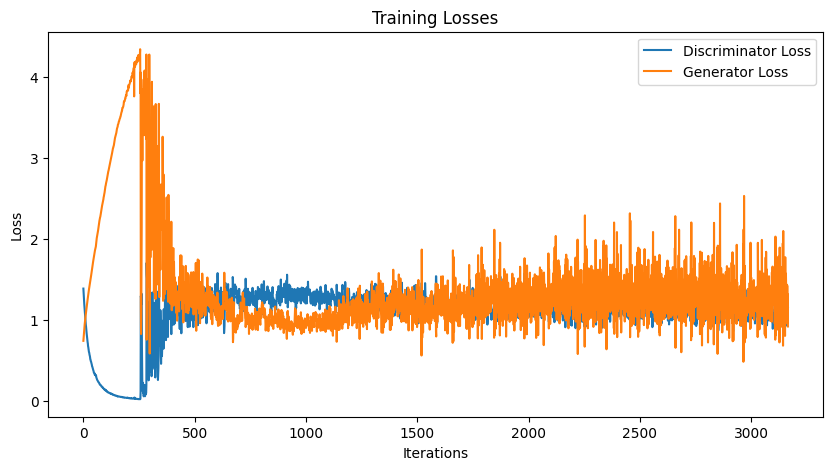

In [58]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(D_loss, label='Discriminator Loss')
plt.plot(G_loss, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


In [59]:
# # saving weights 
# torch.save(G.state_dict(), "generator_final.pth")
# torch.save(D.state_dict(), "discriminator_final.pth")

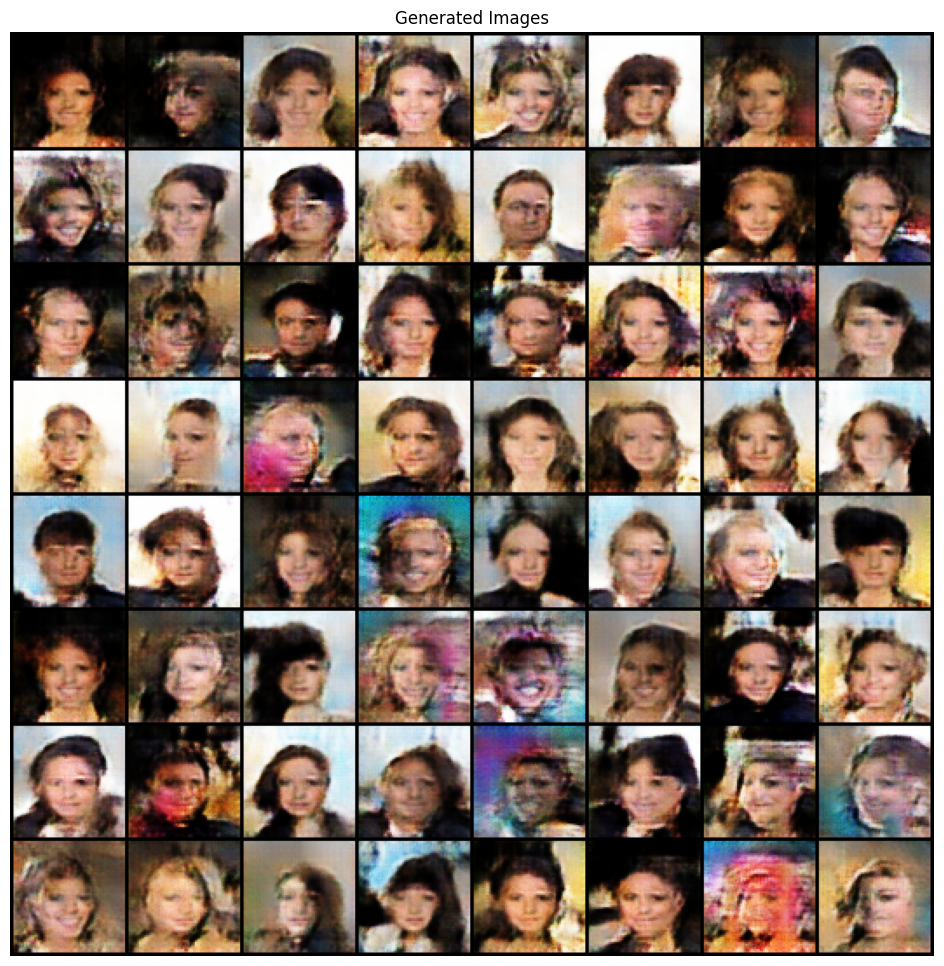

In [60]:
# Function to generate and visualize images
def generate_images(generator, latent_dim, num_images, device, save_path=None):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random noise vectors
    noise = torch.randn((num_images, latent_dim, 1, 1), device=device)

    # Generate fake images
    with torch.no_grad():  # No need to calculate gradients
        fake_images = generator(noise)

    # Normalize the images to [0, 1] for visualization
    fake_images = (fake_images + 1) / 2  # Since the generator outputs images in range [-1, 1]

    # Create a grid of images
    grid = vutils.make_grid(fake_images, nrow=8, normalize=True)

    # Visualize the images
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu())  # Convert CHW to HWC for visualization
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

    
# Example usage
latent_dim = 100
num_images = 64
generate_images(G, latent_dim, num_images, device, save_path="generated_images.png")
